In [1]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99%|████████████████████████████████████████▍| 705M/714M [00:04<00:00, 184MB/s]
100%|█████████████████████████████████████████| 714M/714M [00:04<00:00, 163MB/s]


In [2]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()

patient_id                        images  \
0  TCGA_DU_6405_19851005   TCGA_DU_6405_19851005_6.tif   
1  TCGA_DU_6405_19851005  TCGA_DU_6405_19851005_38.tif   
2  TCGA_DU_6405_19851005  TCGA_DU_6405_19851005_44.tif   
3  TCGA_DU_6405_19851005  TCGA_DU_6405_19851005_32.tif   
4  TCGA_DU_6405_19851005  TCGA_DU_6405_19851005_14.tif   

                               masks  diagnosis  
0   TCGA_DU_6405_19851005_6_mask.tif          0  
1  TCGA_DU_6405_19851005_38_mask.tif          0  
2  TCGA_DU_6405_19851005_44_mask.tif          1  
3  TCGA_DU_6405_19851005_32_mask.tif          0  
4  TCGA_DU_6405_19851005_14_mask.tif          0

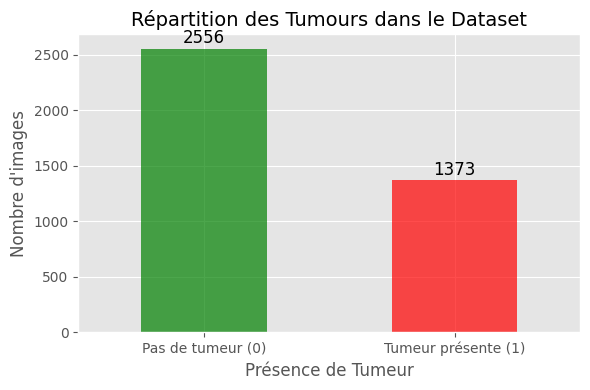

In [5]:
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
pip install imageio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


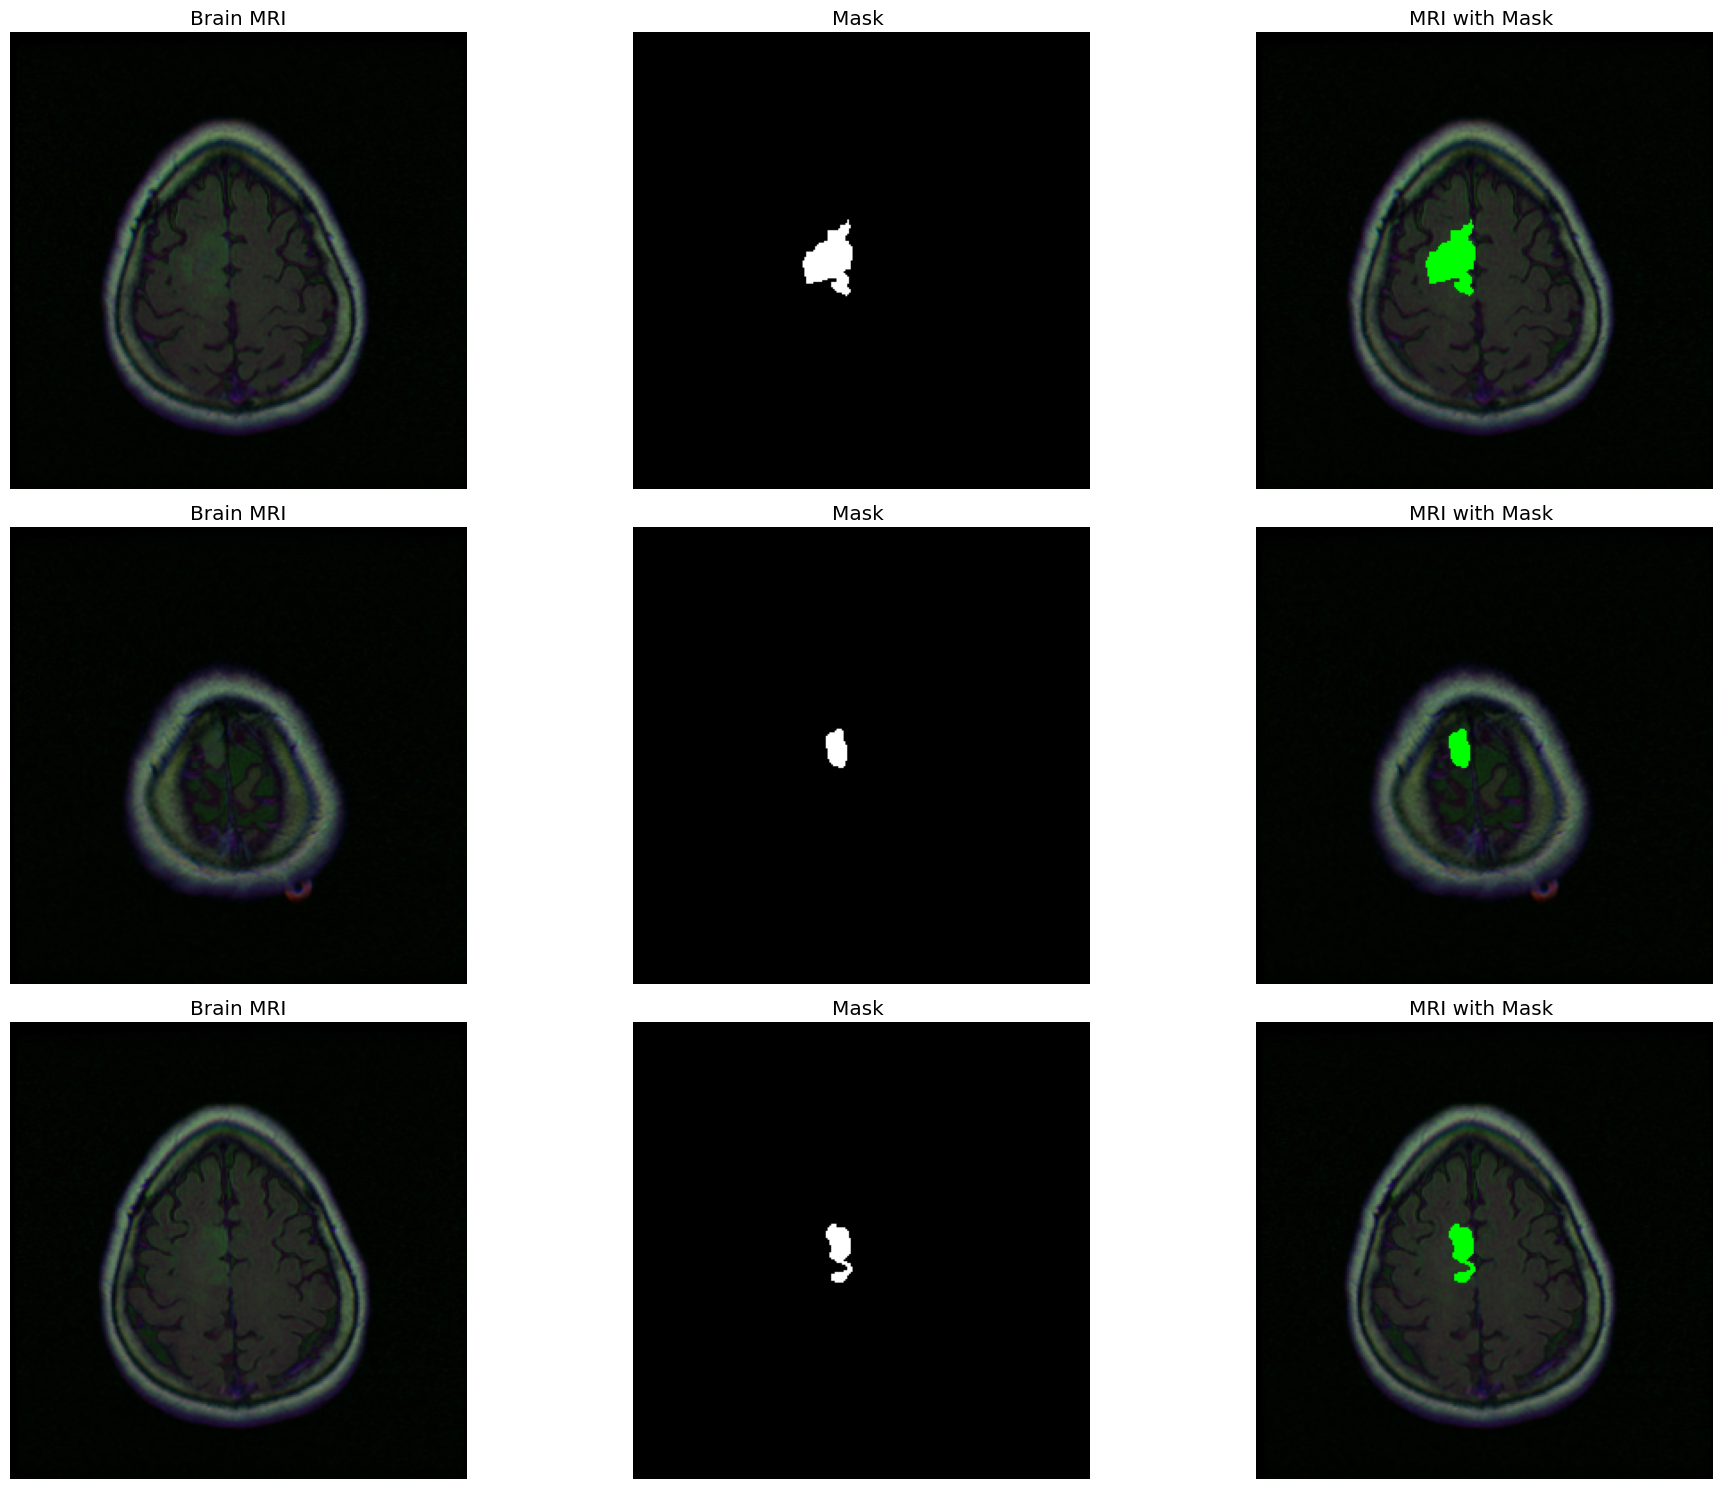

In [7]:
count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path) 

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()

In [8]:

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)
train, val = train_test_split(train, test_size=0.1, random_state=25)
print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(test.head())

Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
1006  TCGA_DU_7014_19860618  TCGA_DU_7014_19860618_51.tif   
1217  TCGA_FG_A4MU_20030903  TCGA_FG_A4MU_20030903_28.tif   
3267  TCGA_DU_6399_19830416  TCGA_DU_6399_19830416_26.tif   
2033  TCGA_FG_7643_20021104  TCGA_FG_7643_20021104_21.tif   
3419  TCGA_DU_5872_19950223  TCGA_DU_5872_19950223_17.tif   

                                  masks  diagnosis  
1006  TCGA_DU_7014_19860618_51_mask.tif          1  
1217  TCGA_FG_A4MU_20030903_28_mask.tif          0  
3267  TCGA_DU_6399_19830416_26_mask.tif          1  
2033  TCGA_FG_7643_20021104_21_mask.tif          0  
3419  TCGA_DU_5872_19950223_17_mask.tif          0  


In [9]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [10]:

def adjust_data(img, mask):
     # Normalisation des images et masques(valeurs entre 0 et 1)
    img = img / 255 
    mask = mask / 255  
    
    # Binarisation des masques
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",  
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks", 
        class_mode=None, 
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=mask_save_prefix,
        seed=seed
    )

    # Fusionner les deux générateurs
    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask) 
        yield img, mask

In [11]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train,  
    batch_size=32,      
    aug_dict=data_augmentation,  
    target_size=(256, 256) 
)
train.head()

patient_id  \
2754  TCGA_HT_7881_19981015   
1556  TCGA_HT_A61A_20000127   
1620  TCGA_HT_A61A_20000127   
1067  TCGA_CS_6669_20020102   
3616  TCGA_DU_6407_19860514   

                                                 images  \
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0

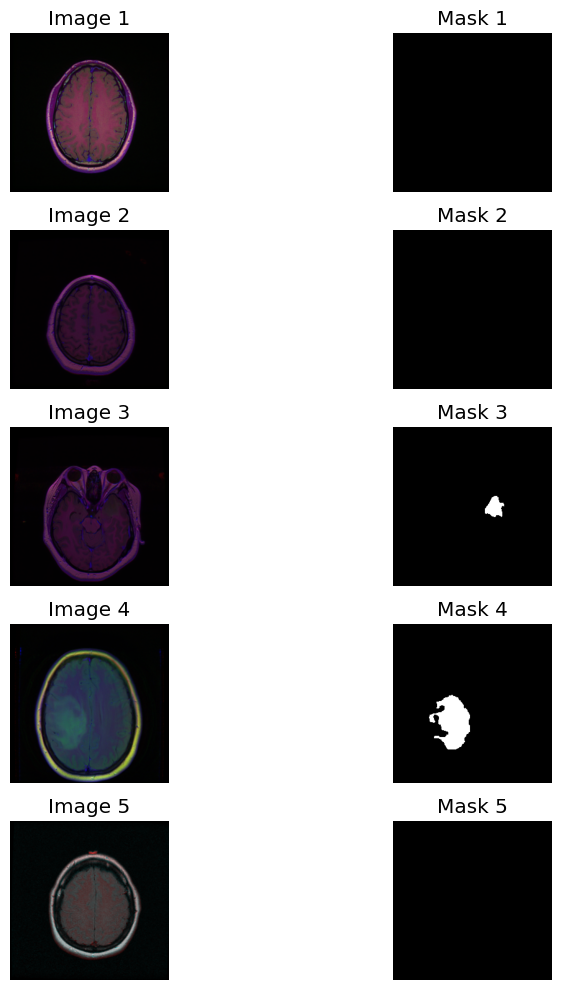

In [12]:

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images'] 
    mask_path = train.iloc[i]['masks']  
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    # Redimensionner si nécessaire (si l'image est grande)
    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Convertir l'image pour l'affichage avec matplotlib (BGR -> RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()

In [13]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val, 
    batch_size=32,     
    aug_dict={},        
    target_size=(256, 256) 
)

In [14]:
# Tester avec un sous-ensemble plus petit du DataFrame pour voir si le générateur fonctionne correctement
small_train_df = train.sample(n=10)  
small_train_generator = data_generator(
    data_frame=small_train_df,  
    batch_size=2,      
    aug_dict=data_augmentation, 
    target_size=(256, 256)
)

sample_small_batch = next(small_train_generator)
print("Small batch image shape:", sample_small_batch[0].shape)
print("Small batch mask shape:", sample_small_batch[1].shape)

Found 10 validated image filenames.
Found 10 validated image filenames.
Small batch image shape: (2, 256, 256, 3)
Small batch mask shape: (2, 256, 256, 1)


In [15]:
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, PReLU, Conv2DTranspose, add, concatenate, Input, Dropout, BatchNormalization
from keras.optimizers import Nadam

def dice_coef(y_true, y_pred, smooth, thresh):
    y_true_f = y_true
    y_pred_f = y_pred
    intersection = K.sum(y_true_f * y_pred_f, axis=(0, 1, 2))
    denom = K.sum(y_true_f, axis=(0, 1, 2)) + K.sum(y_pred_f, axis=(0, 1, 2))
    return K.mean((2. * intersection + smooth) / (denom + smooth))

def dice_loss(smooth, thresh):
    def dice(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred, smooth, thresh)
    return dice

def resBlock(conv, stage, keep_prob, stage_num=5):
    inputs = conv
    for _ in range(3 if stage > 3 else stage):
        conv = PReLU()(BatchNormalization()(Conv2D(16 * (2 ** (stage - 1)), 5, activation=None, padding='same', kernel_initializer='he_normal')(conv)))
    conv_add = PReLU()(add([inputs, conv]))
    conv_drop = Dropout(keep_prob)(conv_add)
    if stage < stage_num:
        conv_downsample = PReLU()(BatchNormalization()(Conv2D(16 * (2 ** stage), 2, strides=(2, 2), activation=None, padding='same', kernel_initializer='he_normal')(conv_drop)))
        return conv_downsample, conv_add
    else:
        return conv_add, conv_add

def up_resBlock(forward_conv, input_conv, stage):
    conv = concatenate([forward_conv, input_conv], axis=-1)
    for _ in range(3 if stage > 3 else stage):
        conv = PReLU()(BatchNormalization()(Conv2D(16 * (2 ** (stage - 1)), 5, activation=None, padding='same', kernel_initializer='he_normal')(conv)))
    conv_add = PReLU()(add([input_conv, conv]))
    if stage > 1:
        conv_upsample = PReLU()(BatchNormalization()(Conv2DTranspose(16 * (2 ** (stage - 2)), 2, strides=(2, 2), padding='valid', activation=None, kernel_initializer='he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights=None, input_size=(256, 256, 3), num_class=1, is_training=True, stage_num=5, thresh=0.5):
    keep_prob = 0.5 if is_training else 0.0
    features = []
    input_model = Input(input_size)
    x = PReLU()(BatchNormalization()(Conv2D(16, 5, activation=None, padding='same', kernel_initializer='he_normal')(input_model)))

    for s in range(1, stage_num + 1):
        x, feature = resBlock(x, s, keep_prob, stage_num)
        features.append(feature)

    conv_up = PReLU()(BatchNormalization()(Conv2DTranspose(16 * (2 ** (stage_num - 2)), 2, strides=(2, 2), padding='valid', activation=None, kernel_initializer='he_normal')(x)))

    for d in range(stage_num - 1, 0, -1):
        conv_up = up_resBlock(features[d - 1], conv_up, d)

    if num_class > 1:
        conv_out = Conv2D(num_class, 1, activation='softmax', padding='same', kernel_initializer='he_normal')(conv_up)
    else:
        conv_out = Conv2D(num_class, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv_up)

    model = Model(inputs=input_model, outputs=conv_out)
    print(model.output_shape)

    model_dice = dice_loss(smooth=1e-5, thresh=0.5)
    model.compile(optimizer=Nadam(learning_rate=2e-4), loss=model_dice, metrics=['accuracy'])

    if pretrained_weights:
        model.load_weights(pretrained_weights)
    return model
model = vnet(input_size=(256, 256, 3), num_class=1, is_training=True, stage_num=5)

model.summary()

(None, 256, 256, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,216 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 256, 256,  │  1,048,576 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      6,416 │ p_re_lu[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 256, 256,  │  1,048,576 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ p_re_lu[0][0],    │
│                     │ 16)               │            │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 256, 256,  │  1,048,576 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ p_re_lu_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,080 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 128, 128,  │    524,288 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     25,632 │ p_re_lu_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 128, 128,  │    524,288 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     25,632 │ p_re_lu_4[0][0] 

 Total params: 23,755,457 (90.62 MB)

 Trainable params: 23,749,825 (90.60 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [16]:
smooth = 100

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred) 
    union = tf.reduce_sum(y_true + y_pred)  
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou


def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_dice_coefficient', patience=8, verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

In [18]:
from tensorflow.keras.metrics import Recall, Precision

learning_rate = 1e-3
EPOCH = 100

model.compile(
    optimizer=Adam(learning_rate=learning_rate), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)
steps_per_epoch = int(len(train) / 32)
validation_steps = int(len(val) / 32)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=validation_steps,
   # callbacks=[lr_reduction, model_checkpoint]
)


82
9
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/100


I0000 00:00:1732010331.828169     123 service.cc:145] XLA service 0x7f5db8001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732010331.828262     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-19 09:59:19.150014: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,16,256,256]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-19 09:59:19.198623: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.04873337s
Trying algorithm eng0{} for conv 

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - dice_coefficient: 0.1115 - iou_score: 0.0618 - loss: 0.8885 - precision: 0.0740 - recall: 0.7823Found 295 validated image filenames.
Found 295 validated image filenames.
82/82 ━━━━━━━━━━━━━━━━━━━━ 110s 623ms/step - dice_coefficient: 0.1126 - iou_score: 0.0624 - loss: 0.8874 - precision: 0.0745 - recall: 0.7821 - val_dice_coefficient: 0.0171 - val_iou_score: 0.0087 - val_loss: 0.9829 - val_precision: 0.0086 - val_recall: 1.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 85s 611ms/step - dice_coefficient: 0.4342 - iou_score: 0.2913 - loss: 0.5645 - precision: 0.4477 - recall: 0.6425 - val_dice_coefficient: 0.0187 - val_iou_score: 0.0144 - val_loss: 0.9830 - val_precision: 0.5336 - val_recall: 0.0062
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 579ms/step - dice_coefficient: 0.6206 - iou_score: 0.4577 - loss: 0.3795 - precision: 0.6910 - recall: 0.6368 - val_dice_coefficient: 0.0951 - val_iou_score: 0.0503 - val_loss: 0.9110 - val_precision: 0.0480 - v

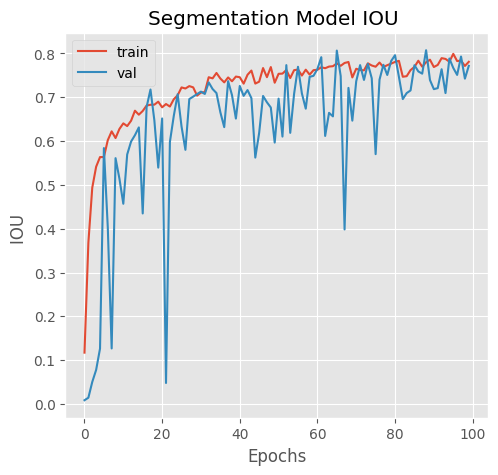

In [26]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU ");
plt.ylabel("IOU ");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

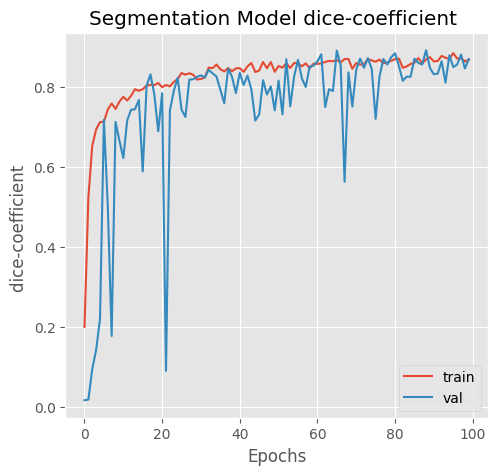

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dice-coefficient ");
plt.ylabel("dice-coefficient ");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

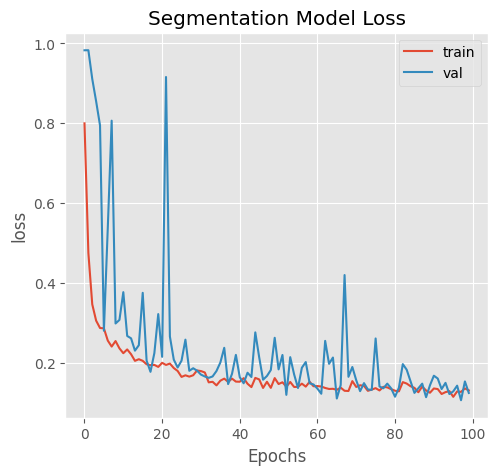

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

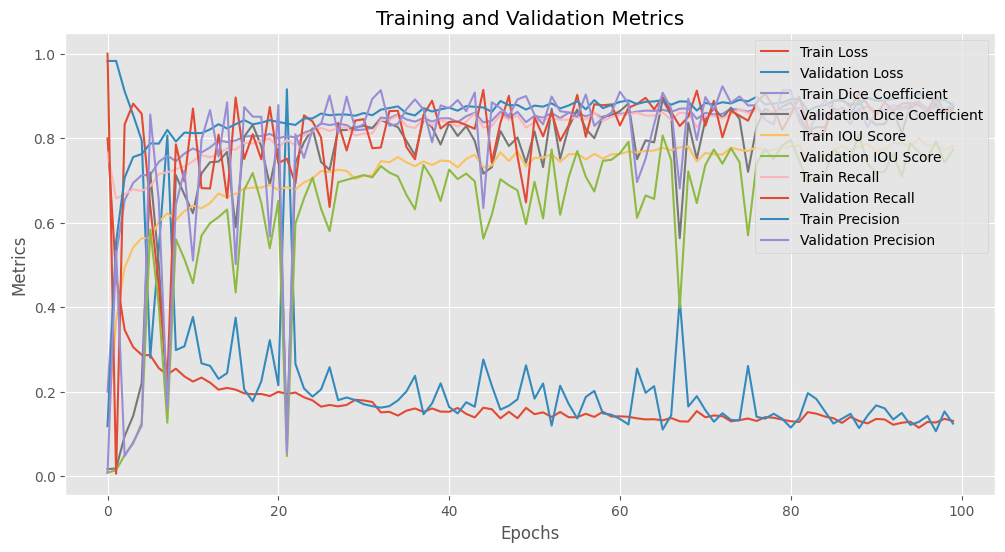

In [25]:
plt.figure(figsize=(12, 6))

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tracer Dice Coefficient
if 'dice_coefficient' in history.history:
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
if 'val_dice_coefficient' in history.history:
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')

# Tracer IOU Score
if 'iou_score' in history.history:
    plt.plot(history.history['iou_score'], label='Train IOU Score')
if 'val_iou_score' in history.history:
    plt.plot(history.history['val_iou_score'], label='Validation IOU Score')

# Tracer Recall
if 'recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
if 'val_recall' in history.history:
    plt.plot(history.history['val_recall'], label='Validation Recall')

# Tracer Precision
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title("Training and Validation Metrics")
plt.ylabel("Metrics")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


In [22]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"
test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())

                 patient_id  \
1006  TCGA_DU_7014_19860618   
1217  TCGA_FG_A4MU_20030903   
3267  TCGA_DU_6399_19830416   
2033  TCGA_FG_7643_20021104   
3419  TCGA_DU_5872_19950223   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  


In [23]:

def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None,  
    color_mode="rgb", 
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False 
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test, 
    x_col="masks",   
    class_mode=None, 
    color_mode="grayscale",  
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32  

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - dice_coefficient: 0.8690 - iou_score: 0.7719 - loss: 0.1310 - precision: 0.8943 - recall: 0.8610
Test Loss: 0.13367144763469696
Test Dice Coefficient: 0.8663285374641418
Test IoU: 0.7681978940963745
Test Recall: 0.8606420159339905
Test Precision: 0.8921487927436829


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


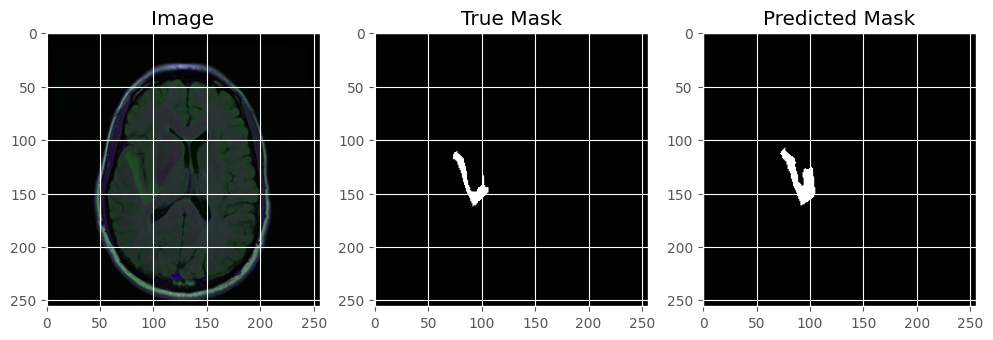

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


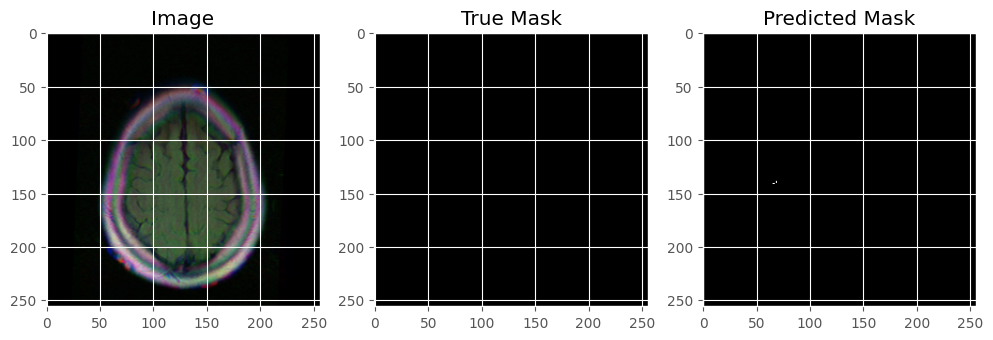

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


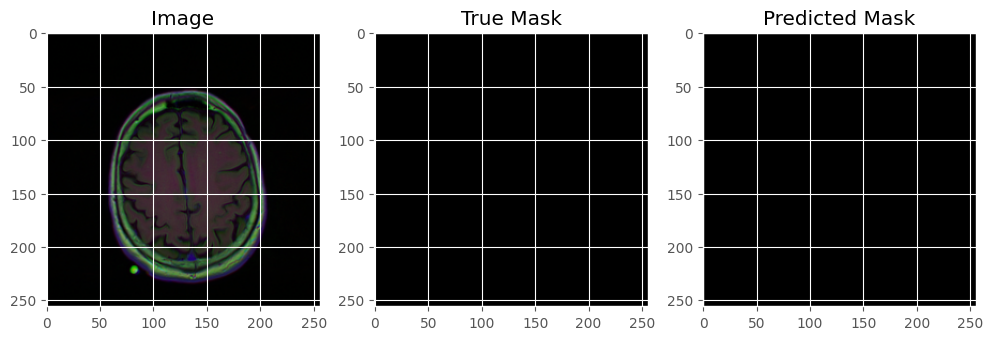

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


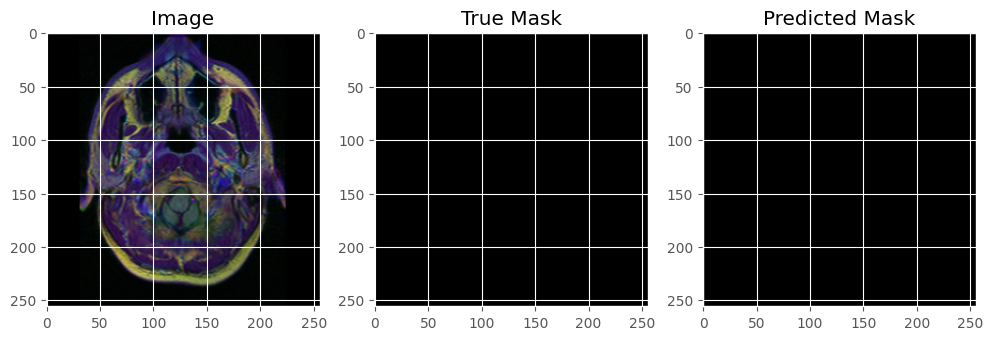

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


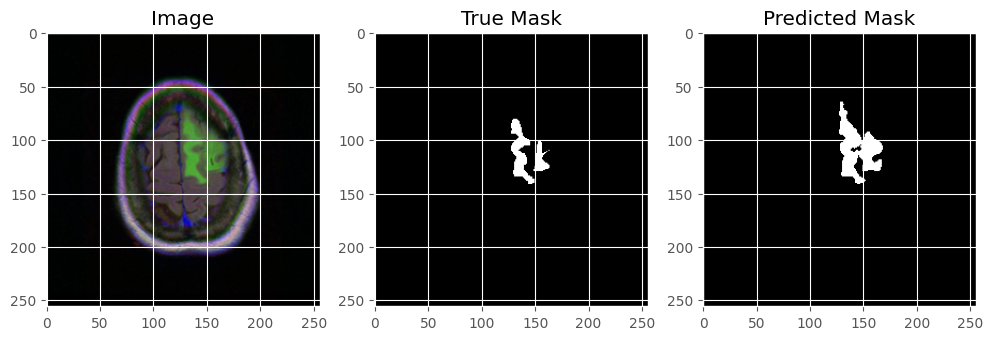

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


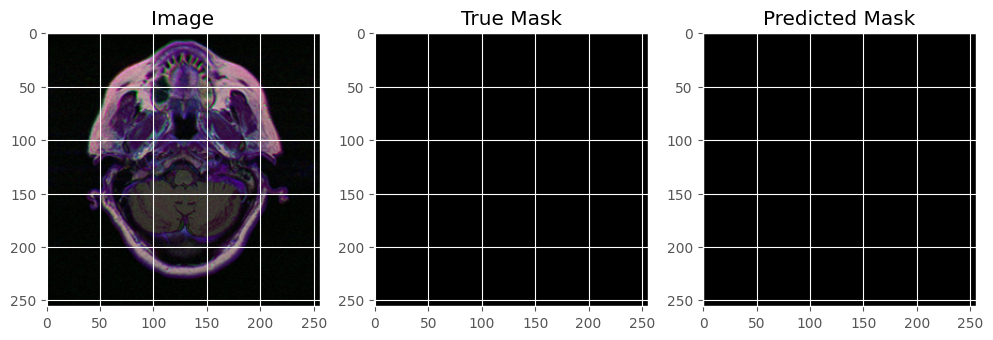

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


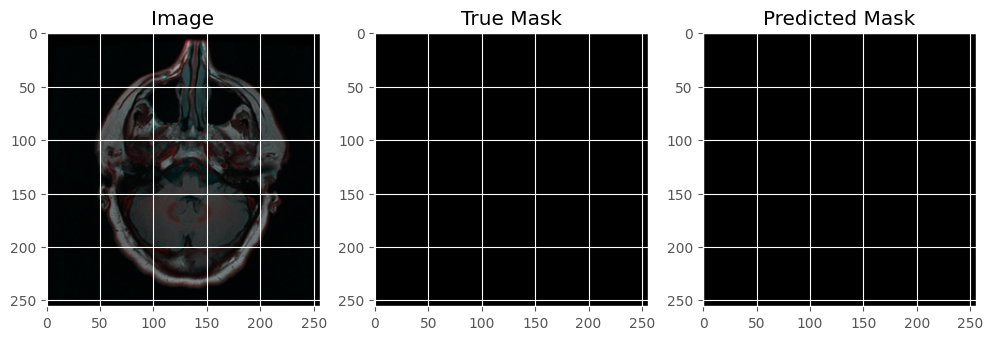

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


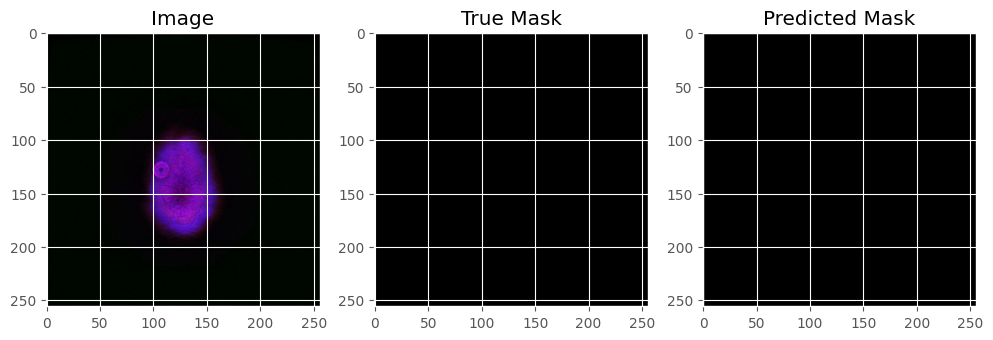

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


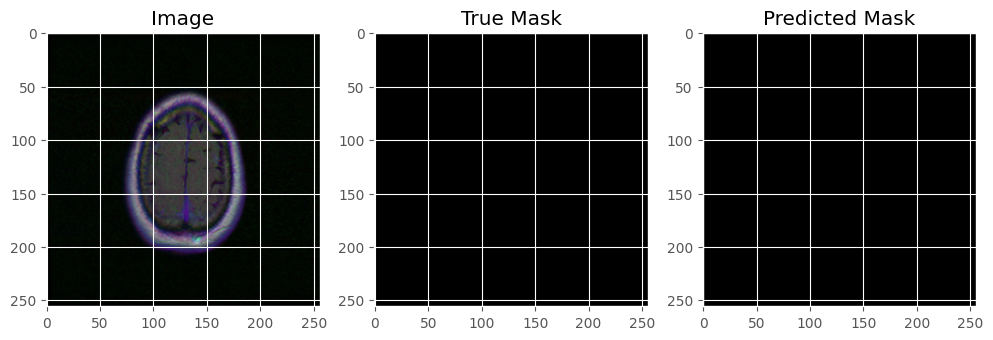

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


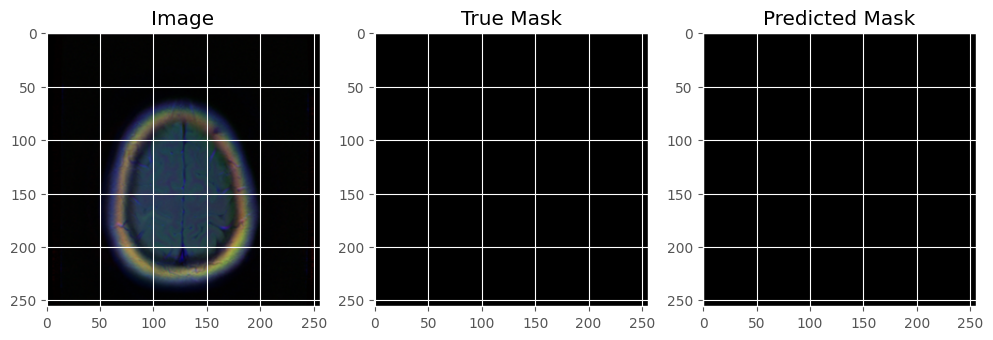

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    # Image d'entrée
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    # Masque prédit binarisé
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


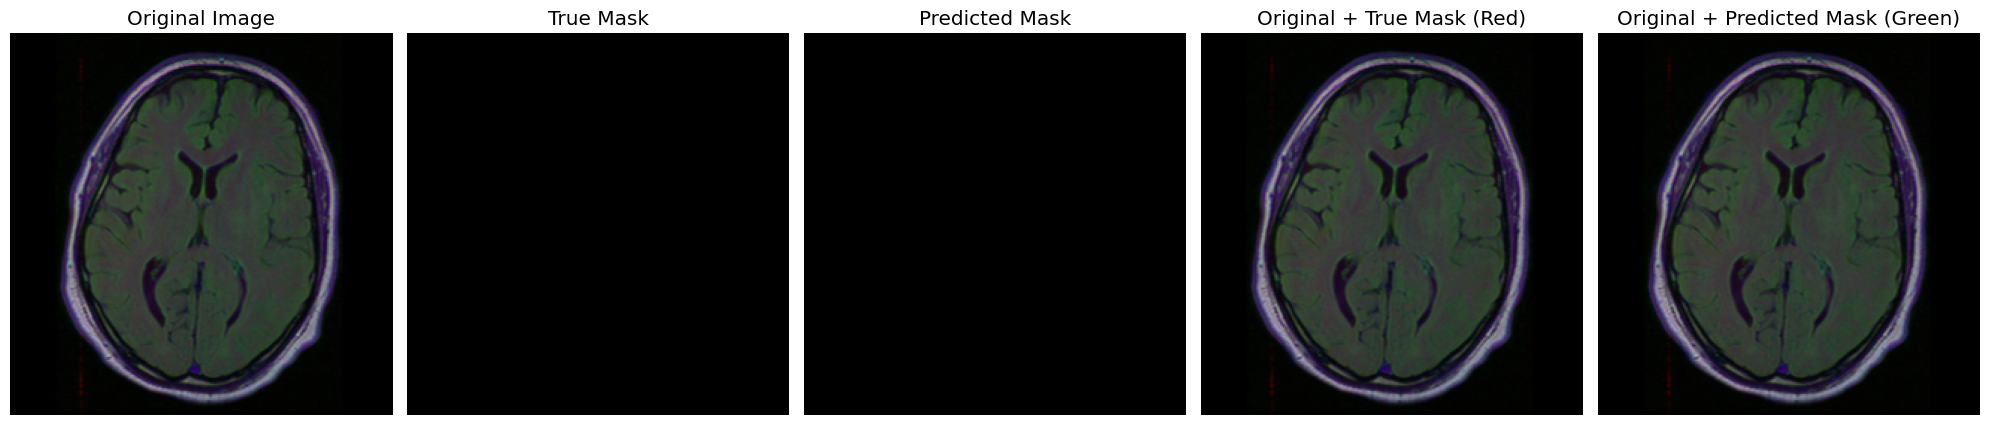

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


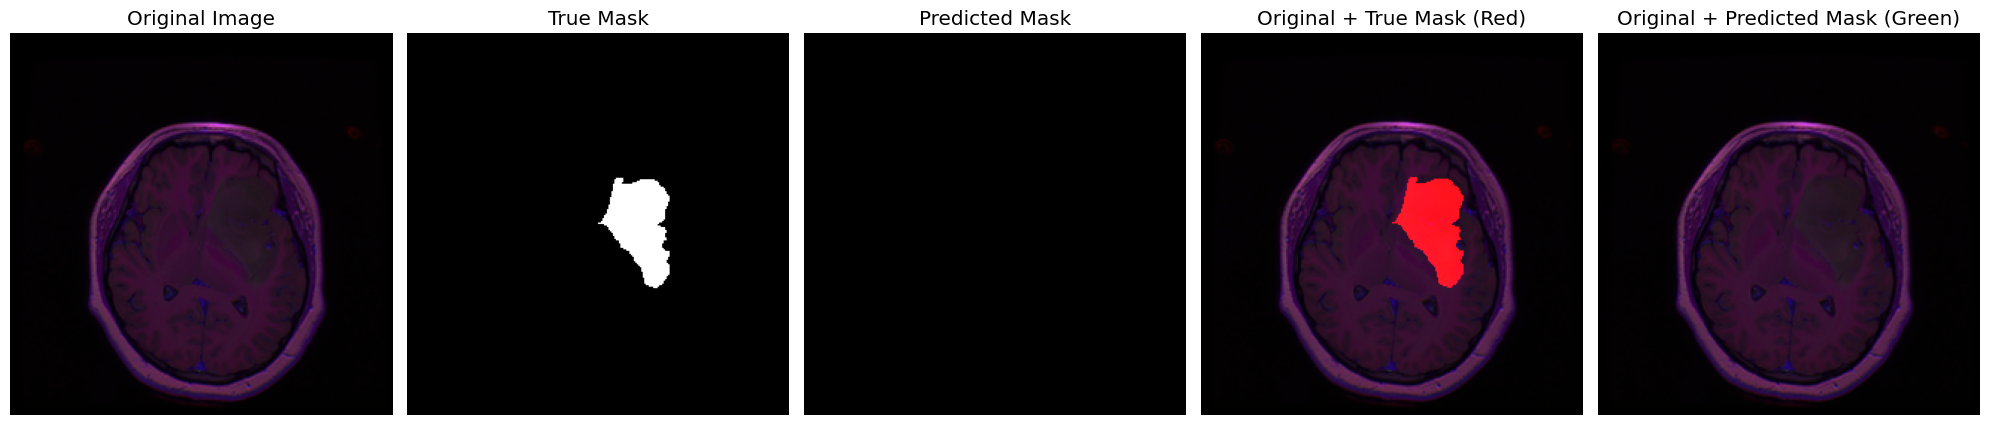

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


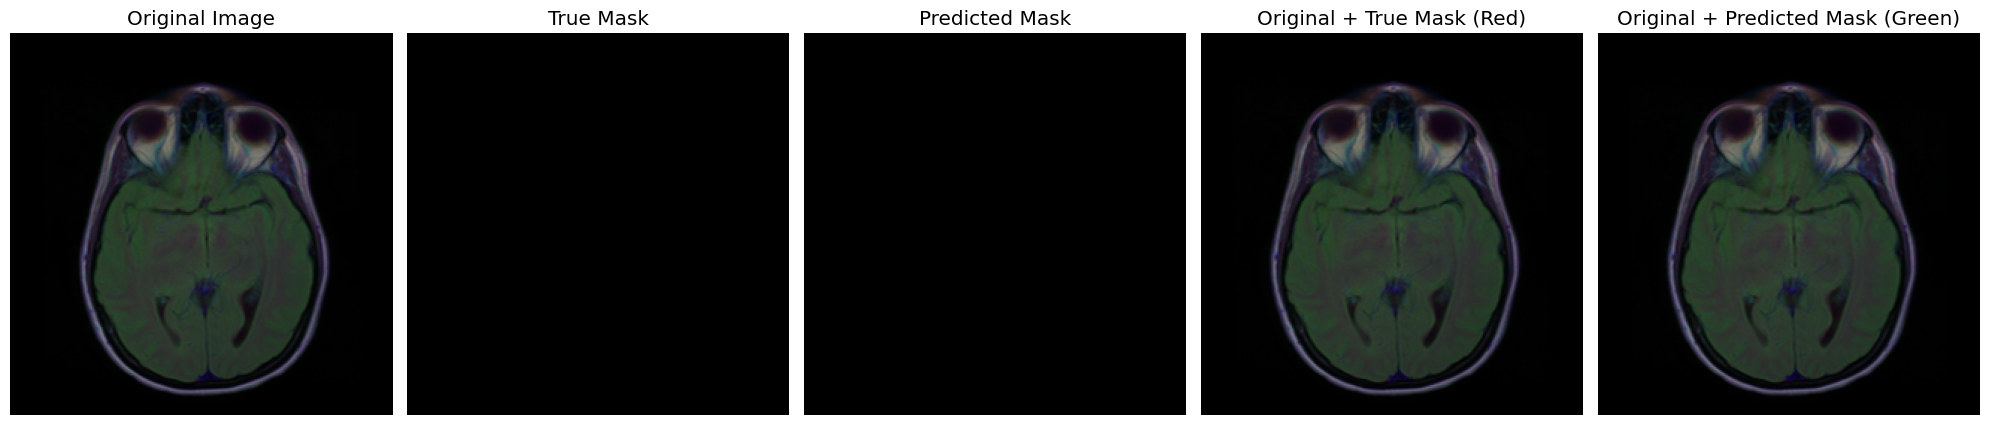

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


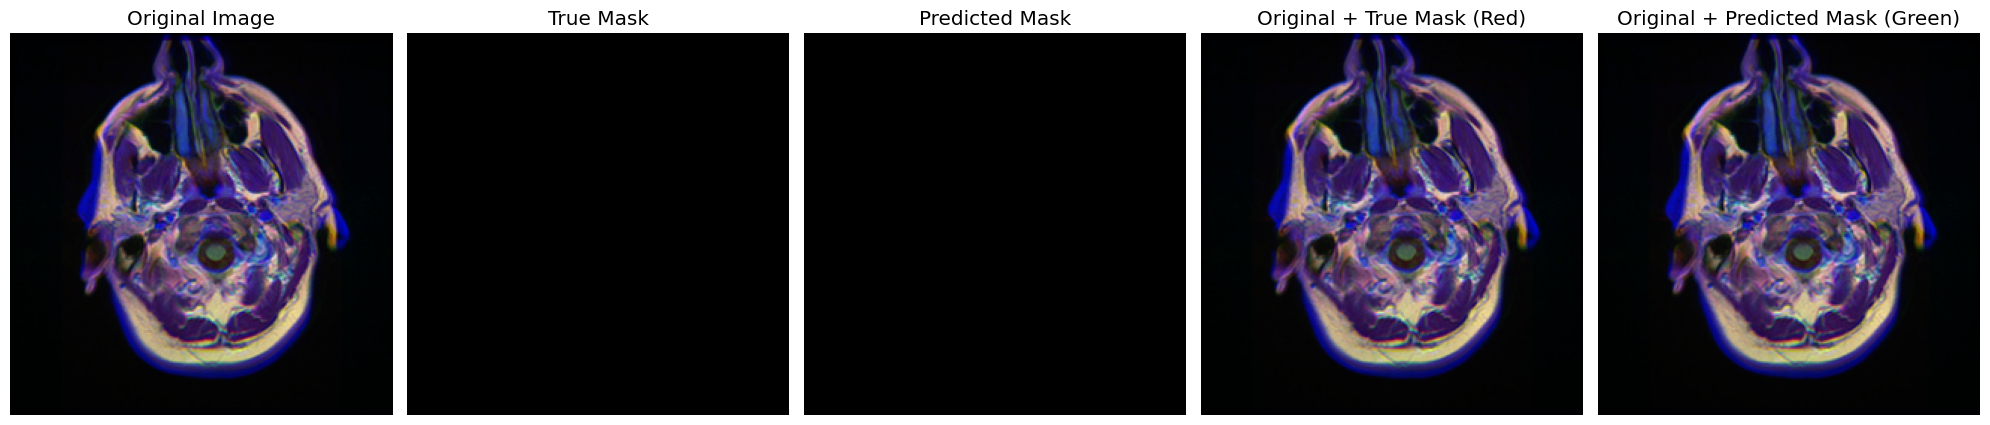

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


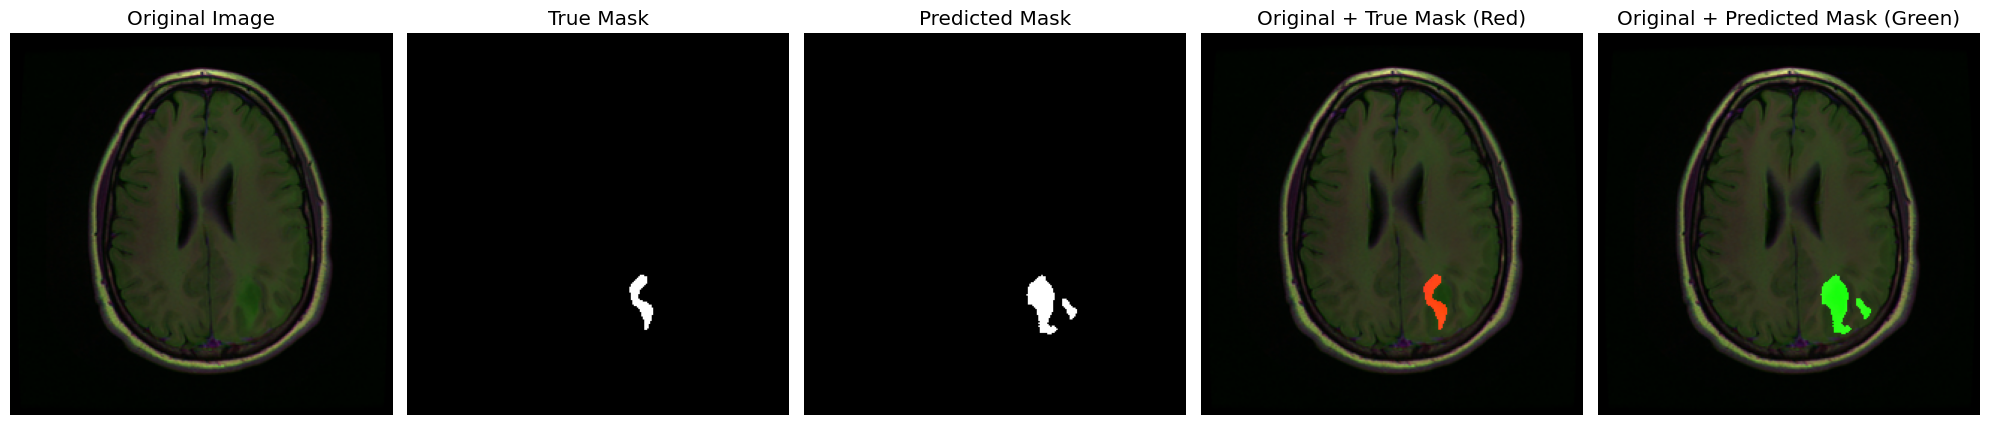

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


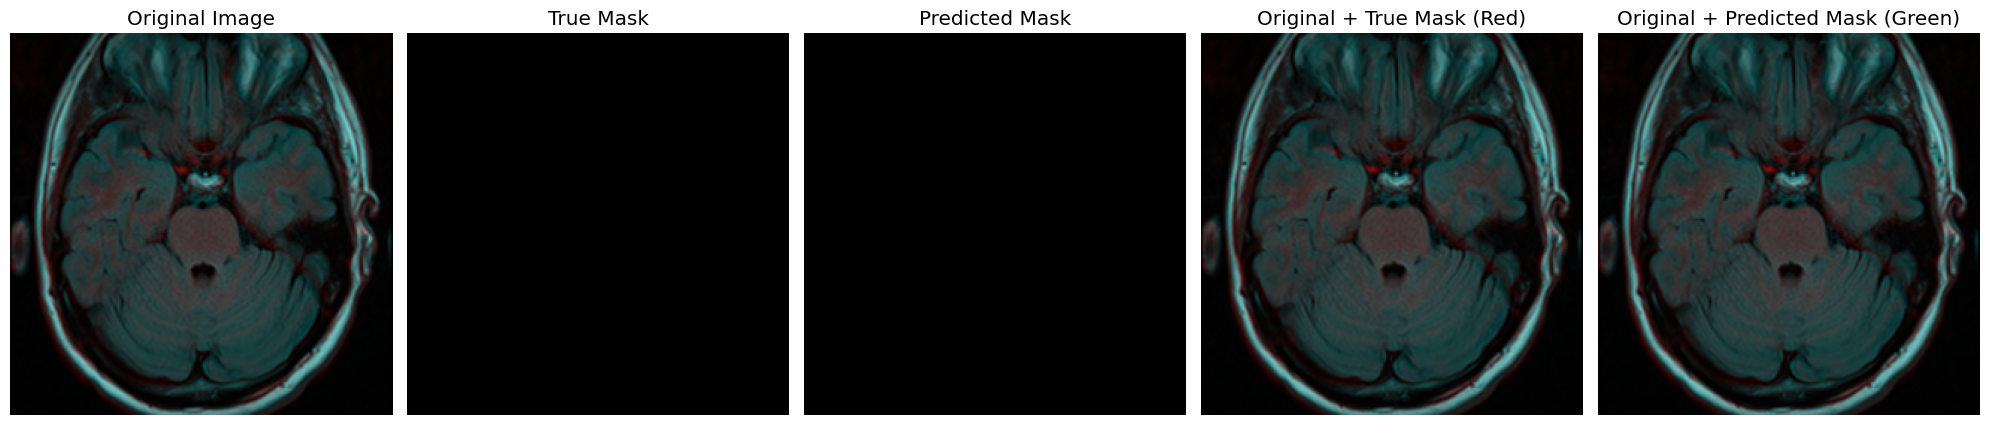

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


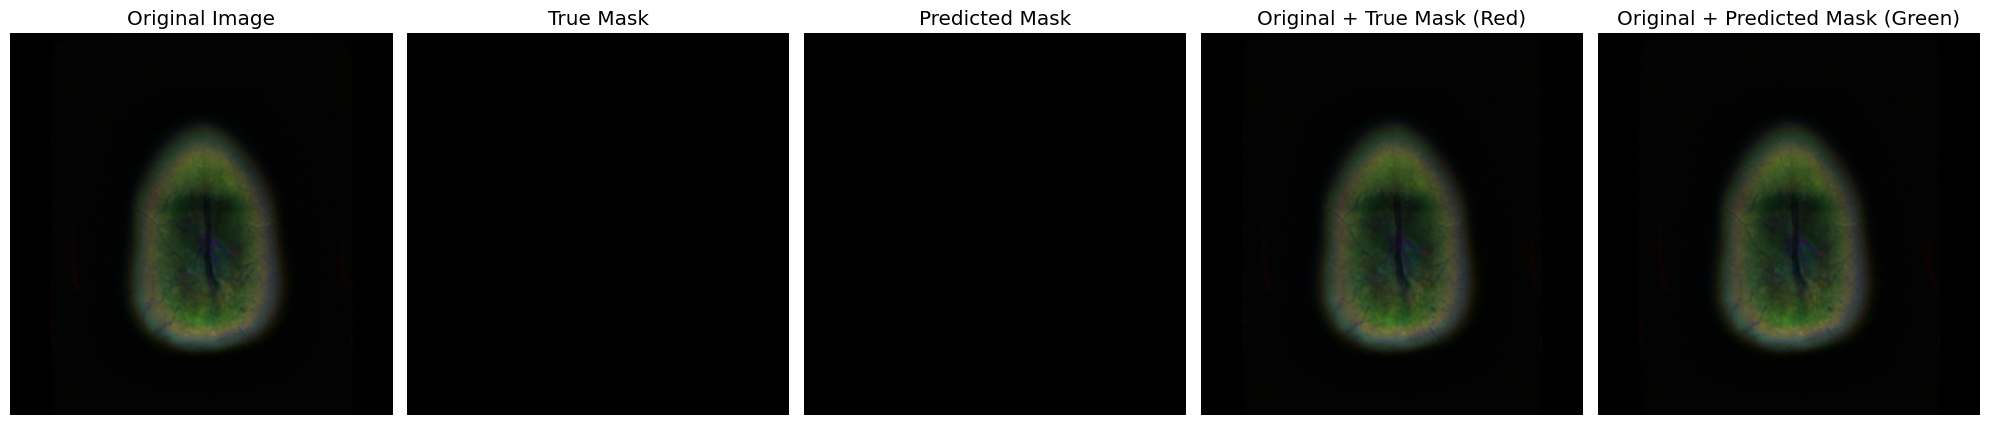

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


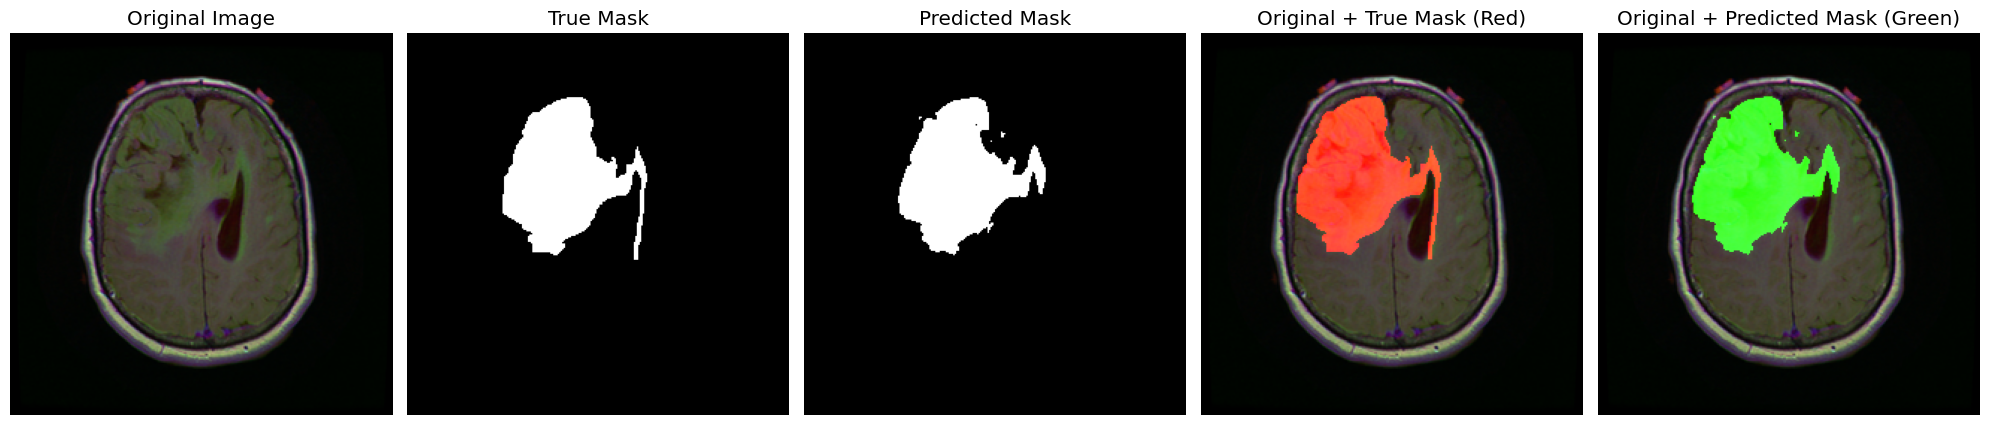

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


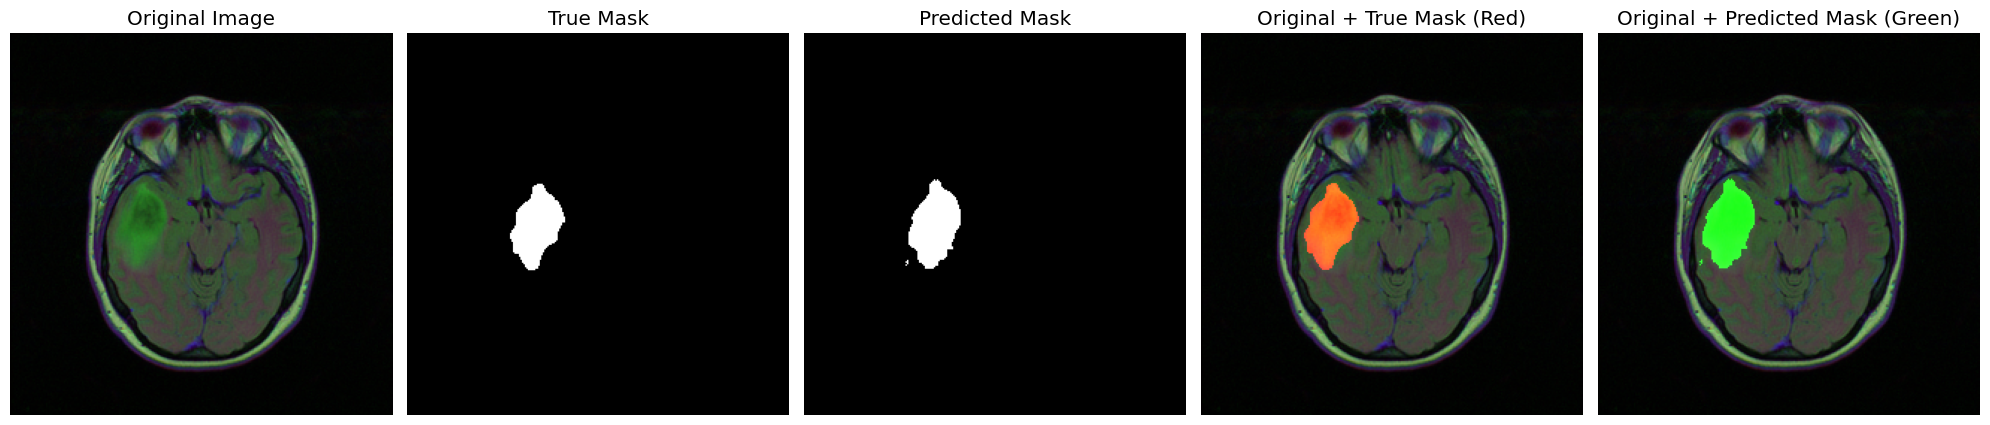

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


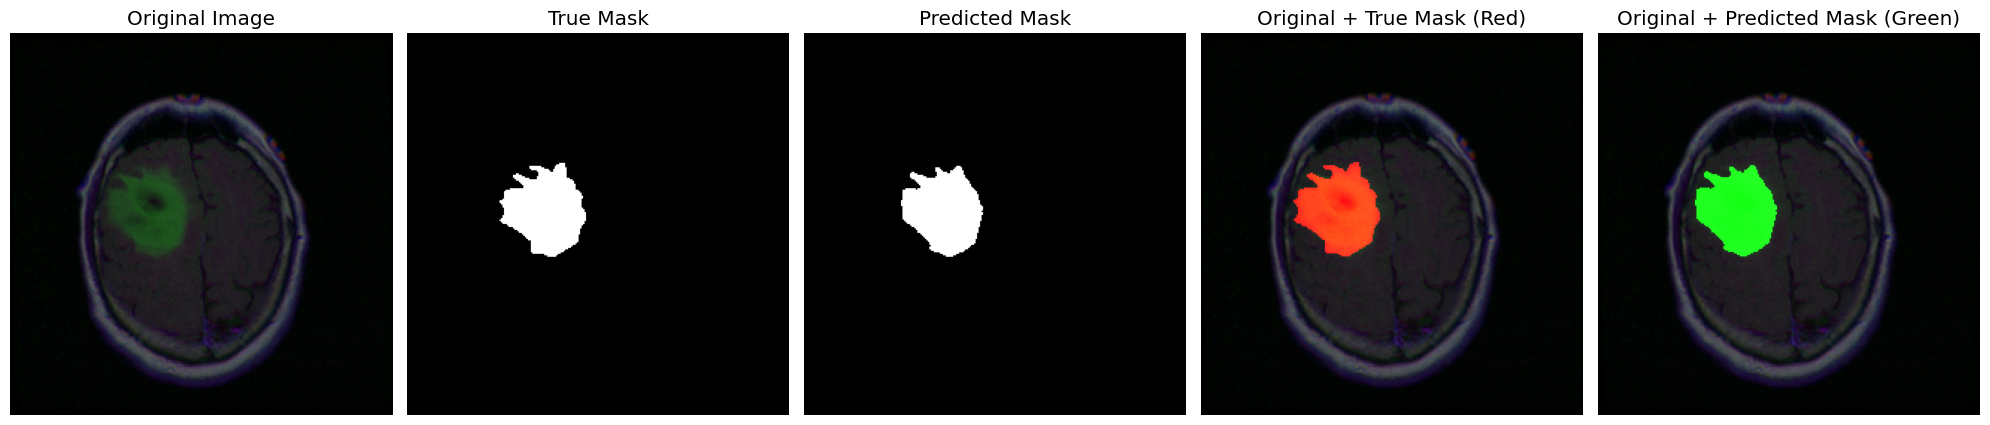

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    image, mask = next(test_generator)
    
    # Prédiction du masque
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    # Création des images avec superpositions
    image_with_true_mask = image[0].copy()  
    image_with_predicted_mask = image[0].copy()  
    # Ajouter le masque réel en rouge
    image_with_true_mask[..., 0] = np.maximum(image_with_true_mask[..., 0], mask[0].squeeze() * 255)  # Rouge

    # Ajouter le masque prédit en vert
    image_with_predicted_mask[..., 1] = np.maximum(image_with_predicted_mask[..., 1], binary_predicted_mask[0].squeeze() * 255)  # Vert
    plt.figure(figsize=(20, 8))

    # Image originale
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 5, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 5, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Image + True Mask
    plt.subplot(1, 5, 4)
    plt.title("Original + True Mask (Red)")
    plt.imshow(image_with_true_mask)
    plt.axis("off")

    # Image + Predicted Mask
    plt.subplot(1, 5, 5)
    plt.title("Original + Predicted Mask (Green)")
    plt.imshow(image_with_predicted_mask)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
